# IoT based gesture recognition 

Gestures are mapped to the corresponding accelerometer and gyroscope values recorded during motion. Here, we have accelerometer and gyroscope values along x, y, z axes recorded 100 times for one gesture, i.e, 600 data points for one gesture.

Dataset: The sensor values were recorded using an app (github link [here](https://github.com/AyishaR/Sensor_data_app)) and consolidates using csv.

Algorithm: A tensorflow deep learning model with relu and softmax activations was used.

![gesture](https://images.unsplash.com/photo-1574676122993-cd7fcf7f9030?ixlib=rb-1.2.1&auto=format&fit=crop&w=500&q=60)

<span>Photo by <a href="https://unsplash.com/@adriensking?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Adrien King</a> on <a href="https://unsplash.com/s/photos/gesture?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Unsplash</a></span>

In [1]:
import pandas as pd
import csv
import os
import tensorflow as tf
import keras
from sklearn.preprocessing import normalize, OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
import urllib

List of gestures used

In [14]:
gestures = ['down_to_up', 'forward_clockwise', 'left_fall', 'up_clockwise', 'up_anticlockwise', 'left_to_right', 'right_to_left', 'forward_fall']

Creating .csv from the .txt obtained from the app.

In [ ]:
'''
#gestures = []
with open('/content/gestures.csv', 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    for fn in os.listdir('/content/gesture'):
        print(fn)
        #gestures.append(fn[:-4])
        f = open('/content/gesture/' + fn)
        lines = f.readlines()
        print(len(lines))
        for line in lines:
            line = line[:-1]
            csvwriter.writerow(line.split(' '))
#print(gestures)

df = pd.read_csv('/content/gestures.csv')

df = df[df['Gesture'] != 'Gesture'].reset_index().drop('index', axis = 'columns')
print(df)
'''

In [ ]:
df.to_csv('gesture60_8_.csv', index = False)

In [7]:
df = pd.read_csv('https://cainvas-static.s3.amazonaws.com/media/user_data/AyishaR0/gesture60_8_.csv')

In [ ]:
# df.describe()

Normalize and shuffle

In [8]:
df[df.columns[:-1]] = normalize(df[df.columns[:-1]])
df = df.sample(frac=1, random_state=13).reset_index(drop = True)
df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,Gesture
0,0.003022,0.093937,0.011679,-0.000629,0.000282,-0.000210,0.002838,0.093238,0.010267,-0.000629,0.000282,-0.000210,0.004020,0.093685,0.009006,-0.000629,0.000282,-0.000210,0.005236,0.093972,0.008237,-0.000629,0.000282,-0.000210,0.005454,0.094155,0.008535,-0.000629,0.000282,-0.000210,0.005465,0.094293,0.007984,-0.000629,0.000282,-0.000210,0.005695,0.094121,0.006069,-0.000629,...,0.024808,0.002097,-0.001888,0.001117,0.082947,-0.008077,0.024808,0.002097,-0.001888,0.001049,0.084003,-0.013629,0.024808,0.002097,-0.001888,0.001370,0.085092,-0.017943,0.024808,0.002097,-0.001888,0.001817,0.087926,-0.019124,0.024808,0.002097,-0.001888,0.000899,0.089934,-0.016520,0.024808,0.002097,-0.001888,0.000016,0.090347,-0.011931,0.024808,0.002097,-0.001888,forward_fall
1,0.000798,0.096556,0.020467,-0.000109,-0.000561,-0.001020,0.000401,0.095487,0.020298,-0.000109,-0.000561,-0.001020,-0.000404,0.094645,0.020262,-0.000109,-0.000561,-0.001020,-0.000392,0.094285,0.021067,-0.000109,-0.000561,-0.001020,0.000389,0.095318,0.021741,-0.000109,-0.000561,-0.001020,0.000774,0.096556,0.023231,-0.000109,-0.000561,-0.001020,0.001195,0.097409,0.024240,-0.000109,...,0.000335,-0.000426,-0.000641,0.006711,0.096712,0.014566,0.000335,-0.000426,-0.000641,0.006459,0.096748,0.014578,0.000335,-0.000426,-0.000641,0.005990,0.097446,0.014409,0.000335,-0.000426,-0.000641,0.005004,0.098046,0.013748,0.000335,-0.000426,-0.000641,0.004668,0.098275,0.013196,0.000335,-0.000426,-0.000641,0.004812,0.097926,0.013797,0.000335,-0.000426,-0.000641,right_to_left
2,0.002546,0.090785,0.027262,0.000192,0.000018,-0.000177,0.004073,0.091596,0.029648,0.000192,0.000018,-0.000177,0.003083,0.092061,0.031008,0.000192,0.000018,-0.000177,0.001711,0.091751,0.032404,0.000192,0.000018,-0.000177,0.001568,0.091656,0.032810,0.000192,0.000018,-0.000177,0.001806,0.092670,0.032153,0.000192,0.000018,-0.000177,0.001639,0.093374,0.031951,0.000192,...,0.000269,0.000499,-0.000634,0.002594,0.103265,-0.009390,0.000269,0.000499,-0.000634,0.002379,0.102119,-0.009008,0.000269,0.000499,-0.000634,0.002737,0.100998,-0.008960,0.000269,0.000499,-0.000634,0.002295,0.100306,-0.009259,0.000269,0.000499,-0.000634,0.003202,0.099697,-0.008268,0.000269,0.000499,-0.000634,0.003202,0.099697,-0.008268,-0.000968,-0.000035,-0.000430,down_to_up
3,0.017293,0.095955,0.019115,-0.000139,0.000187,-0.000324,0.017862,0.096802,0.019986,-0.000139,0.000187,-0.000324,0.018225,0.097274,0.019998,-0.000139,0.000187,-0.000324,0.017100,0.096935,0.019744,-0.000139,0.000187,-0.000324,0.016519,0.096294,0.020761,-0.000139,0.000187,-0.000324,0.016979,0.096524,0.020954,-0.000139,0.000187,-0.000324,0.016192,0.096415,0.020168,-0.000139,...,-0.001582,0.000178,-0.000643,-0.007182,0.098363,0.024753,-0.001582,0.000178,-0.000643,-0.007980,0.098399,0.024378,-0.001582,0.000178,-0.000643,-0.008694,0.098471,0.024850,-0.001582,0.000178,-0.000643,-0.007085,0.099149,0.025285,-0.001582,0.000178,-0.000643,-0.006407,0.100214,0.025261,-0.001582,0.000178,-0.000643,-0.007194,0.099899,0.022321,-0.001582,0.000178,-0.000643,left_to_right
4,-0.000055,0.095312,0.020812,-0.000233,0.000047,0.000046,-0.000883,0.095468,0.022240,-0.000233,0.000047,0.000046,-0.000811,0.095396,0.020680,-0.000233,0.000047,0.000046,-0.000247,0.095024,0.020464,-0.000233,0.000047,0.000046,0.000017,0.095300,0.020848,-0.000233,0.000047,0.000046,0.001385,0.095588,0.020223,-0.000233,0.000047,0.000046,0.000353,0.095816,0.022456,-0.000233,...,0.000294,-0.001089,-0.000150,0.001877,0.090475,-0.002605,0.000294,-0.001089,-0.000150,-0.000475,0.090367,-0.006037,0.000294,-0.001089,-0.000150,-0.000811,0.090487,-0.007058,0.000294,-0.001089,-0.000150,-0.000451,0.090499,-0.005881,0.000294,-0.001089,-0.000150,-0.000559,0.090511,-0.006049,0.000294,-0.001089,

# Visualization

In [10]:
data = pd.DataFrame(df)

In [11]:
col = ['ax','ay','az','gx','gy','gz']*100
col.append('Gesture')
data.columns = col

In [12]:
def extract(gesture,data_dict):
    k = data[data["Gesture"]==gesture].shape[0]
    for j in range(0,k):
        if j == 0:
            data_dict[gesture] = data[data['Gesture']==gesture].iloc[0:1,0:6]
        else:
            data_dict[gesture] = data_dict[gesture].append(data[data['Gesture']==gesture].iloc[j:j+1,0:6])
        for i in range(6,600,6):
            data_dict[gesture] = data_dict[gesture].append(data[data['Gesture']==gesture].iloc[j:j+1,i:i+6])

In [15]:
data_dict = {}
for i in gestures:
    extract(i,data_dict)
    #print(data_dict[i].head())
#data_dict

In [16]:
def visualize(type, gesture):
    for i in gestures:
        title = type.upper()+' for \"'+i.upper()+'\" gesture'
        plt.title(title)
        if type == 'acceleration':
            index = range(1, len(data_dict[i]['ax']) + 1)
            plt.plot(index, data_dict[i]['ax'], 'g.', label='x', linestyle='solid', marker=',')
            plt.plot(index, data_dict[i]['ay'], 'b.', label='y', linestyle='solid', marker=',')
            plt.plot(index, data_dict[i]['az'], 'r.', label='z', linestyle='solid', marker=',')

        if type == 'gyro':
            index = range(1, len(data_dict[i]['ax']) + 1)
            plt.plot(index, data_dict[i]['gx'], 'g.', label='x', linestyle='solid', marker=',')
            plt.plot(index, data_dict[i]['gy'], 'b.', label='y', linestyle='solid', marker=',')
            plt.plot(index, data_dict[i]['gz'], 'r.', label='z', linestyle='solid', marker=',')

        plt.legend()
        plt.show()

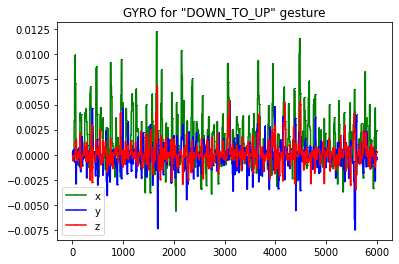

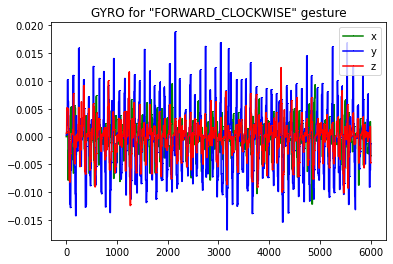

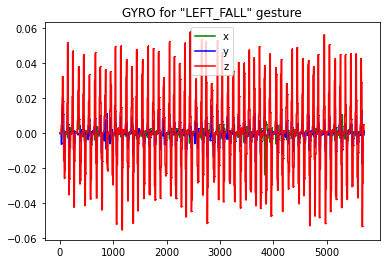

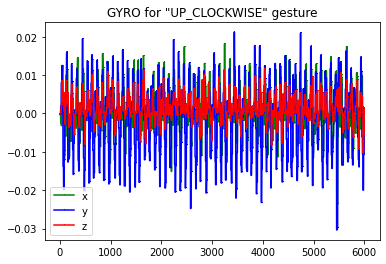

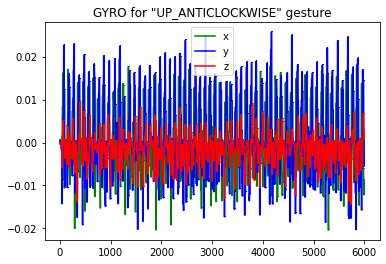

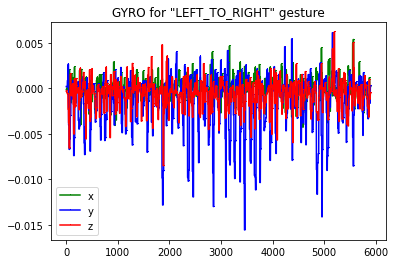

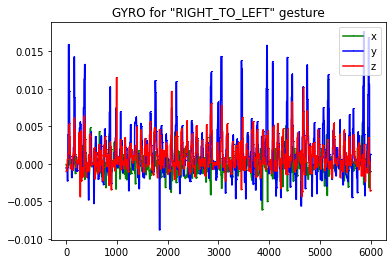

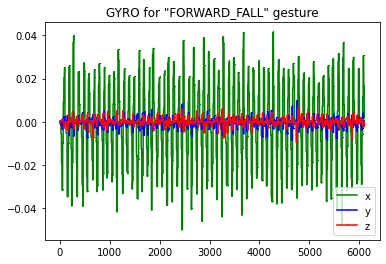

In [17]:
visualize('gyro', gestures)

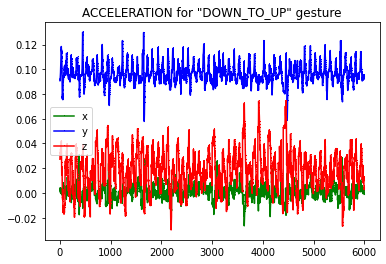

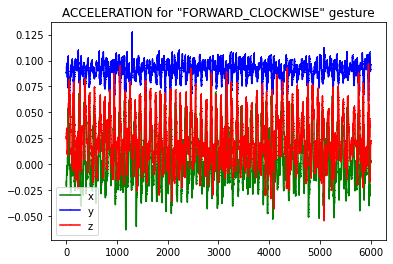

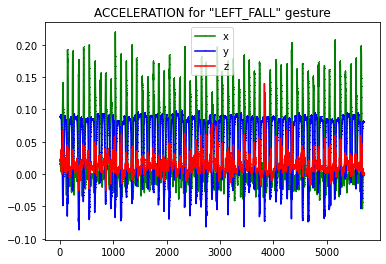

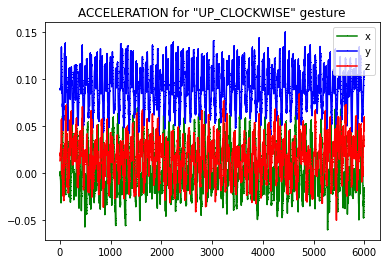

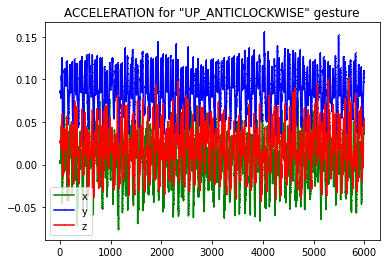

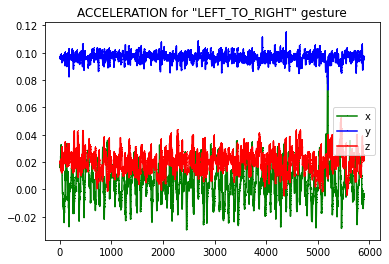

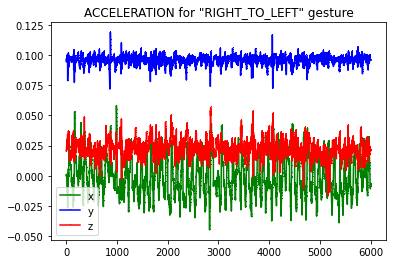

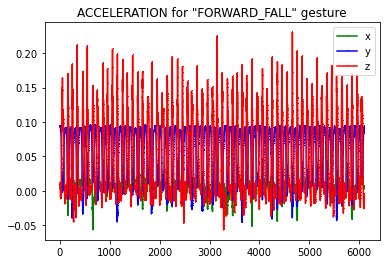

In [18]:
visualize('acceleration', gestures)

Acceleration plot of 'left_to_right' has an outlier.

Identifying and removing it.


In [19]:
outlier = data_dict['left_to_right'][data_dict['left_to_right']['ax'] > 0.06]
print(outlier)

outlier_index = outlier.index.unique().values

df = df.drop(outlier_index).reset_index(drop = True)

           ax        ay        az        gx        gy        gz
421  0.061794  0.082124  0.010391  0.000595  0.000707 -0.000647
421  0.073243  0.082884  0.017196  0.000595  0.000707 -0.000647
421  0.086864  0.083204  0.017766  0.000595  0.000707 -0.000647
421  0.085522  0.082052  0.012932  0.000595  0.000707 -0.000647
421  0.085581  0.077136  0.009168  0.000595  0.000707 -0.000647
421  0.085581  0.077136  0.009168 -0.000697 -0.000800  0.006152
421  0.088123  0.084677  0.007743 -0.000697 -0.000800  0.006152
421  0.084608  0.080722  0.012517 -0.000697 -0.000800  0.006152
421  0.080439  0.075770  0.015783 -0.000697 -0.000800  0.006152
421  0.079596  0.072789  0.021483 -0.000697 -0.000800  0.006152
421  0.078682  0.078228  0.029547 -0.000697 -0.000800  0.006152
421  0.067530  0.080188  0.034677 -0.000697 -0.000800  0.006152


In [20]:
df

,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,...,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,Gesture
0,0.003022,0.093937,0.011679,-0.000629,0.000282,-0.000210,0.002838,0.093238,0.010267,-0.000629,0.000282,-0.000210,0.004020,0.093685,0.009006,-0.000629,0.000282,-0.000210,0.005236,0.093972,0.008237,-0.000629,0.000282,-0.000210,0.005454,0.094155,0.008535,-0.000629,0.000282,-0.000210,0.005465,0.094293,0.007984,-0.000629,0.000282,-0.000210,0.005695,0.094121,0.006069,-0.000629,...,0.024808,0.002097,-0.001888,0.001117,0.082947,-0.008077,0.024808,0.002097,-0.001888,0.001049,0.084003,-0.013629,0.024808,0.002097,-0.001888,0.001370,0.085092,-0.017943,0.024808,0.002097,-0.001888,0.001817,0.087926,-0.019124,0.024808,0.002097,-0.001888,0.000899,0.089934,-0.016520,0.024808,0.002097,-0.001888,0.000016,0.090347,-0.011931,0.024808,0.002097,-0.001888,forward_fall
1,0.000798,0.096556,0.020467,-0.000109,-0.000561,-0.001020,0.000401,0.095487,0.020298,-0.000109,-0.000561,-0.001020,-0.000404,0.094645,0.020262,-0.000109,-0.000561,-0.001020,-0.000392,0.094285,0.021067,-0.000109,-0.000561,-0.001020,0.000389,0.095318,0.021741,-0.000109,-0.000561,-0.001020,0.000774,0.096556,0.023231,-0.000109,-0.000561,-0.001020,0.001195,0.097409,0.024240,-0.000109,...,0.000335,-0.000426,-0.000641,0.006711,0.096712,0.014566,0.000335,-0.000426,-0.000641,0.006459,0.096748,0.014578,0.000335,-0.000426,-0.000641,0.005990,0.097446,0.014409,0.000335,-0.000426,-0.000641,0.005004,0.098046,0.013748,0.000335,-0.000426,-0.000641,0.004668,0.098275,0.013196,0.000335,-0.000426,-0.000641,0.004812,0.097926,0.013797,0.000335,-0.000426,-0.000641,right_to_left
2,0.002546,0.090785,0.027262,0.000192,0.000018,-0.000177,0.004073,0.091596,0.029648,0.000192,0.000018,-0.000177,0.003083,0.092061,0.031008,0.000192,0.000018,-0.000177,0.001711,0.091751,0.032404,0.000192,0.000018,-0.000177,0.001568,0.091656,0.032810,0.000192,0.000018,-0.000177,0.001806,0.092670,0.032153,0.000192,0.000018,-0.000177,0.001639,0.093374,0.031951,0.000192,...,0.000269,0.000499,-0.000634,0.002594,0.103265,-0.009390,0.000269,0.000499,-0.000634,0.002379,0.102119,-0.009008,0.000269,0.000499,-0.000634,0.002737,0.100998,-0.008960,0.000269,0.000499,-0.000634,0.002295,0.100306,-0.009259,0.000269,0.000499,-0.000634,0.003202,0.099697,-0.008268,0.000269,0.000499,-0.000634,0.003202,0.099697,-0.008268,-0.000968,-0.000035,-0.000430,down_to_up
3,0.017293,0.095955,0.019115,-0.000139,0.000187,-0.000324,0.017862,0.096802,0.019986,-0.000139,0.000187,-0.000324,0.018225,0.097274,0.019998,-0.000139,0.000187,-0.000324,0.017100,0.096935,0.019744,-0.000139,0.000187,-0.000324,0.016519,0.096294,0.020761,-0.000139,0.000187,-0.000324,0.016979,0.096524,0.020954,-0.000139,0.000187,-0.000324,0.016192,0.096415,0.020168,-0.000139,...,-0.001582,0.000178,-0.000643,-0.007182,0.098363,0.024753,-0.001582,0.000178,-0.000643,-0.007980,0.098399,0.024378,-0.001582,0.000178,-0.000643,-0.008694,0.098471,0.024850,-0.001582,0.000178,-0.000643,-0.007085,0.099149,0.025285,-0.001582,0.000178,-0.000643,-0.006407,0.100214,0.025261,-0.001582,0.000178,-0.000643,-0.007194,0.099899,0.022321,-0.001582,0.000178,-0.000643,left_to_right
4,-0.000055,0.095312,0.020812,-0.000233,0.000047,0.000046,-0.000883,0.095468,0.022240,-0.000233,0.000047,0.000046,-0.000811,0.095396,0.020680,-0.000233,0.000047,0.000046,-0.000247,0.095024,0.020464,-0.000233,0.000047,0.000046,0.000017,0.095300,0.020848,-0.000233,0.000047,0.000046,0.001385,0.095588,0.020223,-0.000233,0.000047,0.000046,0.000353,0.095816,0.022456,-0.000233,...,0.000294,-0.001089,-0.000150,0.001877,0.090475,-0.002605,0.000294,-0.001089,-0.000150,-0.000475,0.090367,-0.006037,0.000294,-0.001089,-0.000150,-0.000811,0.090487,-0.007058,0.000294,-0.001089,-0.000150,-0.000451,0.090499,-0.005881,0.000294,-0.001089,-0.000150,-0.000559,0.090511,-0.006049,0.000294,-0.001089,-0.000150,-0.000919,0.089743,-

In [ ]:
df.to_csv('gesture60_8_normalized.csv', index = False)

One hot encoding the labels

In [21]:
y_df = pd.get_dummies(df.Gesture)[gestures]
print(y_df)
print(np.array(y_df)[0].shape)

     down_to_up  forward_clockwise  ...  right_to_left  forward_fall
0             0                  0  ...              0             1
1             0                  0  ...              1             0
2             1                  0  ...              0             0
3             0                  0  ...              0             0
4             1                  0  ...              0             0
..          ...                ...  ...            ...           ...
471           0                  0  ...              0             0
472           0                  0  ...              0             0
473           0                  0  ...              1             0
474           0                  0  ...              0             1
475           0                  1  ...              0             0

[476 rows x 8 columns]
(8,)


In [22]:
df = pd.concat([df, y_df], axis=1)
df.head()

,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,...,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,ax,ay,az,gx,gy,gz,Gesture,down_to_up,forward_clockwise,left_fall,up_clockwise,up_anticlockwise,left_to_right,right_to_left,forward_fall
0,0.003022,0.093937,0.011679,-0.000629,0.000282,-0.000210,0.002838,0.093238,0.010267,-0.000629,0.000282,-0.000210,0.004020,0.093685,0.009006,-0.000629,0.000282,-0.000210,0.005236,0.093972,0.008237,-0.000629,0.000282,-0.000210,0.005454,0.094155,0.008535,-0.000629,0.000282,-0.000210,0.005465,0.094293,0.007984,-0.000629,0.000282,-0.000210,0.005695,0.094121,0.006069,-0.000629,...,-0.001888,0.001049,0.084003,-0.013629,0.024808,0.002097,-0.001888,0.001370,0.085092,-0.017943,0.024808,0.002097,-0.001888,0.001817,0.087926,-0.019124,0.024808,0.002097,-0.001888,0.000899,0.089934,-0.016520,0.024808,0.002097,-0.001888,0.000016,0.090347,-0.011931,0.024808,0.002097,-0.001888,forward_fall,0,0,0,0,0,0,0,1
1,0.000798,0.096556,0.020467,-0.000109,-0.000561,-0.001020,0.000401,0.095487,0.020298,-0.000109,-0.000561,-0.001020,-0.000404,0.094645,0.020262,-0.000109,-0.000561,-0.001020,-0.000392,0.094285,0.021067,-0.000109,-0.000561,-0.001020,0.000389,0.095318,0.021741,-0.000109,-0.000561,-0.001020,0.000774,0.096556,0.023231,-0.000109,-0.000561,-0.001020,0.001195,0.097409,0.024240,-0.000109,...,-0.000641,0.006459,0.096748,0.014578,0.000335,-0.000426,-0.000641,0.005990,0.097446,0.014409,0.000335,-0.000426,-0.000641,0.005004,0.098046,0.013748,0.000335,-0.000426,-0.000641,0.004668,0.098275,0.013196,0.000335,-0.000426,-0.000641,0.004812,0.097926,0.013797,0.000335,-0.000426,-0.000641,right_to_left,0,0,0,0,0,0,1,0
2,0.002546,0.090785,0.027262,0.000192,0.000018,-0.000177,0.004073,0.091596,0.029648,0.000192,0.000018,-0.000177,0.003083,0.092061,0.031008,0.000192,0.000018,-0.000177,0.001711,0.091751,0.032404,0.000192,0.000018,-0.000177,0.001568,0.091656,0.032810,0.000192,0.000018,-0.000177,0.001806,0.092670,0.032153,0.000192,0.000018,-0.000177,0.001639,0.093374,0.031951,0.000192,...,-0.000634,0.002379,0.102119,-0.009008,0.000269,0.000499,-0.000634,0.002737,0.100998,-0.008960,0.000269,0.000499,-0.000634,0.002295,0.100306,-0.009259,0.000269,0.000499,-0.000634,0.003202,0.099697,-0.008268,0.000269,0.000499,-0.000634,0.003202,0.099697,-0.008268,-0.000968,-0.000035,-0.000430,down_to_up,1,0,0,0,0,0,0,0
3,0.017293,0.095955,0.019115,-0.000139,0.000187,-0.000324,0.017862,0.096802,0.019986,-0.000139,0.000187,-0.000324,0.018225,0.097274,0.019998,-0.000139,0.000187,-0.000324,0.017100,0.096935,0.019744,-0.000139,0.000187,-0.000324,0.016519,0.096294,0.020761,-0.000139,0.000187,-0.000324,0.016979,0.096524,0.020954,-0.000139,0.000187,-0.000324,0.016192,0.096415,0.020168,-0.000139,...,-0.000643,-0.007980,0.098399,0.024378,-0.001582,0.000178,-0.000643,-0.008694,0.098471,0.024850,-0.001582,0.000178,-0.000643,-0.007085,0.099149,0.025285,-0.001582,0.000178,-0.000643,-0.006407,0.100214,0.025261,-0.001582,0.000178,-0.000643,-0.007194,0.099899,0.022321,-0.001582,0.000178,-0.000643,left_to_right,0,0,0,0,0,1,0,0
4,-0.000055,0.095312,0.020812,-0.000233,0.000047,0.000046,-0.000883,0.095468,0.022240,-0.000233,0.000047,0.000046,-0.000811,0.095396,0.020680,-0.000233,0.000047,0.000046,-0.000247,0.095024,0.020464,-0.000233,0.000047,0.000046,0.000017,0.095300,0.020848,-0.000233,0.000047,0.000046,0.001385,0.095588,0.020223,-0.000233,0.000047,0.000046,0.000353,0.095816,0.022456,-0.000233,...,-0.000150,-0.000475,0.090367,-0.006037,0.000294,-0.001089,-0.000150,-0.000811,0.090487,-0.007058,0.000294,-0.001089,-0.000150,-0.000451,0.090499,-0.005881,0.000294,-0.001089,-0.000150,-0.000559,0.090511,-0.006049,0.000294,-0.001089,-0.000150,-0.000919,0.089743,-0.005857,0.000294,-0.001089,-0.000150,down_to_up,1,0,0,0,0,0,0,0


In [23]:
train_count = int(0.8*len(df))
test_count = len(df) - train_count
print(train_count, test_count)

x_train, y_train = np.array(df)[:train_count, :600].astype('float32'), np.array(df)[:train_count, -(len(gestures)):].astype('int64')
x_test, y_test = np.array(df)[train_count:, :600].astype('float32'), np.array(df)[train_count:, -(len(gestures)):].astype('int64')

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

380 96
(380, 600) (380, 8) (96, 600) (96, 8)


In [ ]:
x_train[0].shape

(600,)

# Model

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(512, activation="relu", input_shape = (600,)))
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(len(gestures), activation="softmax"))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               307712    
_________________________________________________________________
dense_9 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 520       
Total params: 382,152
Trainable params: 382,152
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.fit(x_train, y_train, epochs = 16, batch_size = 8)

Epoch 1/16
48/48 [==============================] - 0s 3ms/step - loss: 1.4661 - accuracy: 0.5632
Epoch 2/16
48/48 [==============================] - 0s 3ms/step - loss: 0.3669 - accuracy: 0.9026
Epoch 3/16
48/48 [==============================] - 0s 3ms/step - loss: 0.1838 - accuracy: 0.9342
Epoch 4/16
48/48 [==============================] - 0s 3ms/step - loss: 0.0833 - accuracy: 0.9816
Epoch 5/16
48/48 [==============================] - 0s 3ms/step - loss: 0.0300 - accuracy: 0.9947
Epoch 6/16
48/48 [==============================] - 0s 3ms/step - loss: 0.0283 - accuracy: 0.9921
Epoch 7/16
48/48 [==============================] - 0s 3ms/step - loss: 0.0148 - accuracy: 1.0000
Epoch 8/16
48/48 [==============================] - 0s 3ms/step - loss: 0.0100 - accuracy: 1.0000
Epoch 9/16
48/48 [==============================] - 0s 3ms/step - loss: 0.0084 - accuracy: 1.0000
Epoch 10/16
48/48 [==============================] - 0s 3ms/step - loss: 0.0039 - accuracy: 1.0000
Epoch 11/16
48/48 [

In [ ]:
model.evaluate(x_test, y_test)

3/3 [==============================] - 0s 3ms/step - loss: 0.1190 - accuracy: 0.9792


[0.1189955398440361, 0.9791666865348816]

# Tiny model

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(16, activation="relu", input_shape = (600,)))
model.add(tf.keras.layers.Dense(8, activation="relu"))
model.add(tf.keras.layers.Dense(4, activation="relu"))
model.add(tf.keras.layers.Dense(len(gestures), activation="softmax"))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 16)                9616      
_________________________________________________________________
dense_29 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_30 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_31 (Dense)             (None, 8)                 40        
Total params: 9,828
Trainable params: 9,828
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x_train, y_train, epochs = 256, batch_size = 32)
print("\n Test set")
model.evaluate(x_test, y_test)

Epoch 1/256
12/12 [==============================] - 0s 2ms/step - loss: 2.0741 - accuracy: 0.1263
Epoch 2/256
12/12 [==============================] - 0s 1ms/step - loss: 2.0636 - accuracy: 0.1684
Epoch 3/256
12/12 [==============================] - 0s 1ms/step - loss: 2.0480 - accuracy: 0.2289
Epoch 4/256
12/12 [==============================] - 0s 1ms/step - loss: 2.0199 - accuracy: 0.3158
Epoch 5/256
12/12 [==============================] - 0s 1ms/step - loss: 1.9893 - accuracy: 0.2789
Epoch 6/256
12/12 [==============================] - 0s 1ms/step - loss: 1.9543 - accuracy: 0.3526
Epoch 7/256
12/12 [==============================] - 0s 1ms/step - loss: 1.9150 - accuracy: 0.3947
Epoch 8/256
12/12 [==============================] - 0s 1ms/step - loss: 1.8714 - accuracy: 0.4553
Epoch 9/256
12/12 [==============================] - 0s 1ms/step - loss: 1.8265 - accuracy: 0.4711
Epoch 10/256
12/12 [==============================] - 0s 1ms/step - loss: 1.7822 - accuracy: 0.4658
Epoch 11/

[0.31812962889671326, 0.9583333134651184]

In [ ]:
y_pred = model.predict(x_test)

for i in range(len(y_pred)):
    m = max(y_pred[i])
    j = np.where(y_pred[i] == m)[0][0]
    k = np.where(y_test[i] == 1)[0][0]
    if(j!=k):
        print("------- Mismatch -------")
    print("Actual: " + gestures[k] + "\nPredicted: " + gestures[j] + "\nConfidence: " + str(m) + "\n")

Actual: up_clockwise
Predicted: up_clockwise
Confidence: 0.999985

Actual: up_clockwise
Predicted: up_clockwise
Confidence: 0.91623324

Actual: up_anticlockwise
Predicted: up_anticlockwise
Confidence: 0.99999845

Actual: forward_fall
Predicted: forward_fall
Confidence: 0.9994973

Actual: forward_fall
Predicted: forward_fall
Confidence: 0.99971145

Actual: left_to_right
Predicted: left_to_right
Confidence: 0.9927014

Actual: down_to_up
Predicted: down_to_up
Confidence: 0.99834216

------- Mismatch -------
Actual: up_clockwise
Predicted: forward_clockwise
Confidence: 0.7707691

Actual: up_clockwise
Predicted: up_clockwise
Confidence: 0.9999733

Actual: left_fall
Predicted: left_fall
Confidence: 0.99983704

Actual: forward_clockwise
Predicted: forward_clockwise
Confidence: 0.99986076

Actual: down_to_up
Predicted: down_to_up
Confidence: 0.9999119

Actual: left_fall
Predicted: left_fall
Confidence: 0.9999583

Actual: down_to_up
Predicted: down_to_up
Confidence: 0.99755657

Actual: left_fal

In [ ]:
model.save('gestureTinyModel.h5')

In [24]:
model = tf.keras.models.load_model('gestureTinyModel.h5')

In [25]:
model.evaluate(x_test, y_test)

3/3 [==============================] - 0s 2ms/step - loss: 0.3181 - accuracy: 0.9583


[0.31812968850135803, 0.9583333134651184]

In [ ]:
!deepCC iot/gestureTinyModel.h5

-std=c++11 -O3
reading [keras model] from 'iot/gestureTinyModel.h5'
Saved 'gestureTinyModel.onnx'
reading onnx model from file  gestureTinyModel.onnx
Model info:
  ir_vesion :  3 
  doc       : 
WARN (ONNX): terminal (input/output) dense_8_input's shape is less than 1.
             changing it to 1.
WARN (ONNX): terminal (input/output) dense_11's shape is less than 1.
             changing it to 1.
WARN (GRAPH): found operator node with the same name (dense_11) as io node.
running DNNC graph sanity check ... passed.
Writing C++ file  gestureTinyModel_deepC/gestureTinyModel.cpp
INFO (ONNX): model files are ready in dir gestureTinyModel_deepC
g++ -O3 -I. -I/opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg/deepC/include -isystem /opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg/deepC/packages/eigen-eigen-323c052e1731 gestureTinyModel_deepC/gestureTinyModel.cpp -o gestureTinyModel_deepC/gestureTinyModel.exe
Model executable  gestureTiny

# Gesture based home automation

The below snippet is a poc for gesture based home automation - controlling the various appliances at home with gestures.

The aim is to embed the sensors in a wearable device. 

We move our hands in so many different ways and there is a high chance that one of these many movements map to the recorded gestures and trigger responses. To counter this, we can include a tiny button/other mechanism to indicate the start of the gesture.

---

List of gestures and the various categories for reference, mapped to the list of gestures above. 

Here, count refers to moving to the next instance of the appliance (eg, countIncrease - moving from fan1 to fan2, countDecrease - moving from fan2 to fan1) and next refers to choosing the next appliance.

In [ ]:
gesture_key = {}
gesture_key["appliance"] = ["light", "fan"]
gesture_key["operation"] = ["switch", "increase", "decrease"]
gesture_key["count"] = ["countIncrease", "countDecrease"]
gesture_key["next"] = ["next"]


gestures_home = []
for x in gesture_key:
    gestures_home.extend(gesture_key[x])

print(gestures_home)

['light', 'fan', 'switch', 'increase', 'decrease', 'countIncrease', 'countDecrease', 'next']


In [ ]:
input_file = open('/content/test7.txt')
lines = input_file.readlines()
 
#lines = urllib.request.urlopen('https://cainvas-static.s3.amazonaws.com/media/user_data/AyishaR0/test3.txt').read()
#lines = lines.decode('utf-8').split('\n')[:-1]
 
appliance_bool = True
operation_bool = False
 
# mapping each appliance to the operations that can be done on them
 
appliance_to_operation = {'light' : {'switch'}, 
                          'fan' : {'switch', 'increase', 'decrease'}}
 
# descriptions and cuurent state of the configured (installed) appliances  
configured = {}
configured['light'] = { 1 : ["off"], 
                       2 : ["off"]}
configured['fan'] = { 1 : ["off", 0, 5]}        # 0 - cuurent speed, 5 - maximum
 
# list of operations performed (just for reference) 
performed = []
 
# initializations 
count = 0
appliance = ""
 
for line in lines[1:]:      # first line of text file contains column headings
 
    line = line.split(' ')[:-1]     # last value is gesture name which is blank here
    line = np.array(line).astype('float32').reshape(1,600)
 
    result = model.predict(normalize(line))
    m = max(result[0])
    g = gestures_home[np.where(result[0] == m)[0][0]]
    print("Recognized: " + g + " with " + str(m) + " confidence level.")
    
    # if appliance is to be selected
    if (appliance_bool):
        
        if g in configured:
            print("Selected " + g)
            
            # initializing instance of appliance
            count = 0
 
            # Setting appliance selection to false and operation on appliance to true
            appliance_bool = False
            operation_bool = True
            
            # keeping track of current appliance
            appliance = g
            
            performed.append([g, "Selected"])
        
        else:
            print("Invalid gesture. Try again!")
    
    # if operation is to be done on appliance
    elif (operation_bool):
 
        # gesture to move to next instance of appliance
        if g == 'countIncrease':
            if count < len(configured[appliance]):
                count = count + 1
                print("Instance " + str(count) + " of " + appliance + " selected.")
                performed.append([appliance, g, count])
            else:
                print("Last instance reached.")
 
        # gesture to move to previous instance of appliance
        elif g == 'countDecrease':
            if count > 1:
                count = count - 1
                print("Instance " + str(count) + " of " + appliance + " selected.")
                performed.append([appliance, g, count])
            else:
                print("First instance reached.")
 
        # gesture to change current selelcted appliance
        elif g == 'next':            
            print("Change appliance")
            application = ""
 
            # Setting appliance selection to true and operation on appliance to false
            appliance_bool = True
            operation_bool = False  
 
            performed.append(['Changed'])
 
        # gesture to perform an operation on the selelcted appliance (checking if the operation is valid for the selected appliance)
        elif g in appliance_to_operation[appliance]:
            
            # checking if instance of appliance is selected
            if count !=0:
                
                # toggle switch on/off
                if g == 'switch':
                    configured[appliance][count][0] = 'on' if configured[appliance][count][0]=='off' else 'off'
 
                    performed.append([appliance, g, configured[appliance][count][0]])
 
                    print("Instance " + str(count) + " of " + appliance + " switched " + configured[appliance][count][0])
 
                # increase fan speed    
                elif g == 'increase':
                    if configured[appliance][count][1]<configured[appliance][count][2]:
                        configured[appliance][count][1] = configured[appliance][count][1] + 1
 
                        performed.append([appliance, g, configured[appliance][count][1]])
 
                        print("Instance " + str(count) + " of " + appliance + " - speed increased to " + str(configured[appliance][count][1]))
                    else:
                        print("Max speed reached!")
 
                #decrease fan speed
                elif g == 'decrease':
                    if configured[appliance][count][1] > 0:
                        configured[appliance][count][1] = configured[appliance][count][1] - 1
 
                        performed.append([appliance, g, configured[appliance][count][1]])
 
                        print("Instance " + str(count) + " of " + appliance + " - speed decreased to " + str(configured[appliance][count][1]))
                    else:
                        print("Min speed reached!")
            else:
                print('Select instance of appliance to work with!')
        else:
            print("Invalid operation for appliance!")
    print()
 
print('\nOperations performed')
for x in performed:
    print(x)
 
print('\nFinal state of appliances')
print(configured)

Recognized: light with 0.5605731 confidence level.
Selected light

Recognized: switch with 0.99834716 confidence level.
Select instance of appliance to work with!

Recognized: countIncrease with 0.99767834 confidence level.
Instance 1 of light selected.

Recognized: switch with 0.9934098 confidence level.
Instance 1 of light switched on

Recognized: next with 0.9998223 confidence level.
Change appliance

Recognized: fan with 0.9281305 confidence level.
Selected fan

Recognized: countIncrease with 0.763762 confidence level.
Instance 1 of fan selected.

Recognized: switch with 0.9990729 confidence level.
Instance 1 of fan switched on

Recognized: countIncrease with 0.5193476 confidence level.
Last instance reached.

Recognized: increase with 0.9976655 confidence level.
Instance 1 of fan - speed increased to 1

Recognized: decrease with 1.0 confidence level.
Instance 1 of fan - speed decreased to 0

Recognized: next with 0.9999951 confidence level.
Change appliance


Operations performed


# Other applications

* Sign language convertor 
    
    Embedded in a wearable, this allows the gestures performed to be mapped to voice output.
